In [1]:
# Train a CNN regression to predict the mCG level of all DMRs
import pandas as pd
import numpy as np
import time, re
import matplotlib.pyplot as plt

# Quantify mCG at the enhancers

In [2]:
# bed_file='enhancers_reptile.bed'
# allc_dir='/cndd2/fangming/scf_enhancers/data/bulk/round2/mc/'
# allc_files=glob.glob(allc_dir+'Round2*CGN-Merge.allc.tsv.gz')

# # bed_file='foo.bed'
# # allc_files = [allc_files[0]]

# output_files = ['enh.'+os.path.split(a)[1][:-22]+'.bed.gz' for a in allc_files]
# cap = 0 # no counts cap
# nprocs = 8
# compress = True
# bed_file_name_column = False
# chr_prefix = True
# contexts = ['CG']

# run_mc_region_level(allc_files, 
#                     output_files, 
#                     bed_file, 
#                     chr_prefix=chr_prefix,
#                     bed_file_name_column=bed_file_name_column,
#                     contexts=contexts,
#                     compress=compress, 
#                     cap=cap,
#                     nprocs=nprocs);

In [3]:
# # Gather data from all the individual bed files
# df = pd.DataFrame();
# for fn in output_files:
    
#     _, sample = os.path.split(fn)
#     sample = re.sub('(enh\.|\.bed)','',sample)

#     x = pd.read_csv(fn+'.gz',sep='\t')
#     x=x.rename(mapper={'mCG': sample+'_'+'mCG', 'CG': sample+'_'+'CG'}, axis=1)
#     if df.shape[0]<1:
#         df = x
#     else:
#         df = df.join(x.iloc[:,[3,4]])
        
# df['enh_pos'] = 'chr'+df['chr'].astype(str)+'_'+df['start'].astype(str)+'_'+df['end'].astype(str)

In [4]:
# df.to_csv('enh.AllClusters.mCG.bed.gz')

In [5]:
# for fn in output_files:
#     os.remove(fn)
#     print('Removed file %s' % fn)

# Load enhancer data

In [6]:
# # Add strand info to the bed file for each gene
# transcripts = pd.read_csv(datadir+'gencode_vM16_transcript_annotation.bed',sep='\t',
#                           header=None,
#                           names=['trans_chr','trans_start','trans_end','strand','ensmust','gene_name_trans','ensid_full','gene_name'])
# transcripts['ensid'] = [re.sub("\..*","",x) for x in transcripts.ensid_full]
# transcripts = transcripts.set_index('ensid',drop=False)
# transcripts
# 
# genes = pd.read_csv(datadir+'genes.gencode.vM16.bed',sep='\t',header=None,
#                    names=['chr','start','end','ensid','gene'])
# genes['ensid'] = [re.sub('\..*','',ensid) for ensid in genes['ensid']]
# genes = genes.set_index('ensid',drop=False)
# genes = genes.iloc[[x!='chrY' for x in genes['chr']],:]

# genes=genes.join(transcripts.loc[:,['ensid','strand']].drop_duplicates().loc[:,'strand'])
# genes = genes.loc[:,['chr','start','end','strand','ensid','gene']]
# genes.to_csv(datadir+'genes.gencode.vM16.strand.bed',sep='\t',index=False,header=False)
# genes

datadir = '/cndd/emukamel/enhancer_modeling/enhancer_data/'
genes = pd.read_csv(datadir+'genes.gencode.vM16.strand.bed',sep='\t',header=None,
                   names=['chr','start','end','strand','ensid','gene'])
genes = genes.set_index('ensid',drop=False)
genes

,chr,start,end,strand,ensid,gene
ensid,,,,,,
ENSMUSG00000102693,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik
ENSMUSG00000064842,chr1,3102016,3102125,+,ENSMUSG00000064842,Gm26206
ENSMUSG00000051951,chr1,3205901,3671498,-,ENSMUSG00000051951,Xkr4
ENSMUSG00000102851,chr1,3252757,3253236,+,ENSMUSG00000102851,Gm18956
ENSMUSG00000103377,chr1,3365731,3368549,-,ENSMUSG00000103377,Gm37180
...,...,...,...,...,...,...
ENSMUSG00000086695,chrX,169985801,169986939,-,ENSMUSG00000086695,Gm15247
ENSMUSG00000095562,chrX,170009659,170019281,+,ENSMUSG00000095562,Gm21887
ENSMUSG00000093806,chrX,170672644,170678054,+,ENSMUSG00000093806,Asmt


In [7]:
# Map the genes to closest enhancers
datadir = '/cndd/emukamel/enhancer_modeling/enhancer_data/'
genes2enh = pd.read_csv(datadir+'genes.gencode.vM16.enhancers_within_100kb.bed',sep='\t',
                        names = ['gene_chr','gene_start','gene_end','gene_strand','ensid','gene_name','enh_chr','enh_start','enh_end'])

slopsize=int(1e5)
genes2enh['enh_end'] = genes2enh['enh_end']-slopsize
genes2enh['enh_start'] = genes2enh['enh_start']+slopsize

get_tss = lambda x : x['gene_start'] if (x['gene_strand']=='+') else x['gene_end']
genes2enh['tss'] = genes2enh.apply(get_tss, axis=1)

genes2enh['enh_ctr'] = (genes2enh['enh_start']+genes2enh['enh_end'])/2

In [8]:
# Get signed distance to the TSS
genes2enh['dtss'] = (genes2enh['enh_ctr']-genes2enh['tss']) * ((genes2enh['gene_strand']=='+')*2-1)
genes2enh = genes2enh.loc[genes2enh['enh_start']!=-1,:]
genes2enh

,gene_chr,gene_start,gene_end,gene_strand,ensid,gene_name,enh_chr,enh_start,enh_end,tss,enh_ctr,dtss
0,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik,chr1,3083769,3083816,3073253,3083792.5,10539.5
1,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik,chr1,3112234,3112467,3073253,3112350.5,39097.5
2,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik,chr1,3112770,3112986,3073253,3112878.0,39625.0
3,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik,chr1,3113717,3114035,3073253,3113876.0,40623.0
4,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik,chr1,3118790,3118935,3073253,3118862.5,45609.5
...,...,...,...,...,...,...,...,...,...,...,...,...
1500315,chrX,170009659,170019281,+,ENSMUSG00000095562,Gm21887,chrX,169927115,169927682,170009659,169927398.5,-82260.5
1500316,chrX,170009659,170019281,+,ENSMUSG00000095562,Gm21887,chrX,169935048,169935204,170009659,169935126.0,-74533.0
1500317,chrX,170672644,170678054,+,ENSMUSG00000093806,Asmt,.,99999,-100001,170672644,-1.0,-170672645.0
1500318,chrX,170746836,170747207,-,ENSMUSG00000096661,Gm15069,.,99999,-100001,170747207,-1.0,170747208.0


In [9]:
genes2enh['enh_pos'] = genes2enh['enh_chr']+'_'+genes2enh['enh_start'].astype(str)+'_'+genes2enh['enh_end'].astype(str)

In [10]:
genes2enh.ensid = [re.sub("\..*","",x) for x in genes2enh.ensid]
genes2enh = genes2enh.set_index('ensid', drop=False)
genes2enh

,gene_chr,gene_start,gene_end,gene_strand,ensid,gene_name,enh_chr,enh_start,enh_end,tss,enh_ctr,dtss,enh_pos
ensid,,,,,,,,,,,,,
ENSMUSG00000102693,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik,chr1,3083769,3083816,3073253,3083792.5,10539.5,chr1_3083769_3083816
ENSMUSG00000102693,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik,chr1,3112234,3112467,3073253,3112350.5,39097.5,chr1_3112234_3112467
ENSMUSG00000102693,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik,chr1,3112770,3112986,3073253,3112878.0,39625.0,chr1_3112770_3112986
ENSMUSG00000102693,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik,chr1,3113717,3114035,3073253,3113876.0,40623.0,chr1_3113717_3114035
ENSMUSG00000102693,chr1,3073253,3074322,+,ENSMUSG00000102693,4933401J01Rik,chr1,3118790,3118935,3073253,3118862.5,45609.5,chr1_3118790_3118935
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000095562,chrX,170009659,170019281,+,ENSMUSG00000095562,Gm21887,chrX,169927115,169927682,170009659,169927398.5,-82260.5,chrX_169927115_169927682
ENSMUSG00000095562,chrX,170009659,170019281,+,ENSMUSG00000095562,Gm21887,chrX,169935048,169935204,170009659,169935126.0,-74533.0,chrX_169935048_169935204
ENSMUSG00000093806,chrX,170672644,170678054,+,ENSMUSG00000093806,Asmt,.,99999,-100001,170672644,-1.0,-170672645.0,._99999_-100001


# Load RNA data

In [11]:
# datadir='/cndd2/ethan/projects/scf_paper/modeling/working_data/reptile/data_for_model_01152020/' # 10x vs scRNA
# rna = pd.read_csv(datadir+'rna_for_y_values.tsv',sep='\t')
# rcol = rna.columns.values
# rcol[1] = 'ensid'
# rna.columns = rcol
# # rna=rna.drop('10-1',axis=1)
# # rna_data = rna.iloc[:,2:].to_numpy()

# # Variable genes
# hvg = np.var(rna.iloc[:,2:].to_numpy(),axis=1);
# hvg = hvg> np.percentile(hvg,50)
# np.sum(hvg)

# rna = rna[hvg]

In [12]:
# rna = rna.set_index('ensid')

In [13]:
# Load different RNA datasets
rnadir = '/cndd/emukamel/BICCN-Mouse-MOp/supp_tables/Table_S5_GeneByCluster/'
scf_l2 = ['1-1-1', '1-2-1', '1-2-2', '10-1-1', '2-1-1', '2-1-2',
       '2-2-1', '2-2-2', '2-2-3', '2-2-4', '2-3-1', '2-3-2', '2-3-3', '3-1-1',
       '3-1-2', '3-2-1', '3-2-2', '3-3-1', '4-1-1', '4-1-2', '4-2-1', '4-2-2',
       '4-2-3', '5-1-1', '5-1-2', '5-2-1', '5-2-2', '5-2-3', '5-3-1', '5-3-2',
       '5-4-1', '5-5-1', '6-1-1', '6-1-2', '6-2-1', '6-3-1', '6-3-2', '6-3-3',
       '6-4-1', '6-4-2', '6-5-1', '6-5-2', '6-5-3', '6-6-1', '7-1-1', '7-1-2',
       '7-2-1', '7-2-2', '8-1-1', '8-1-2', '8-2-1', '8-3-1', '8-3-2', '9-1-1',
       '9-2-1', '9-2-2']
scf_l1,scf_l1i = np.unique(np.array([re.sub('-[0-9]$','', i) for i in scf_l2]),return_inverse=True)
scf_l1,scf_l1i

fn = rnadir+'Table_S5b_gene_counts_scRNA_10X_v3_A.tsv.gz'
data_l2 = pd.read_csv(fn,sep='\t',index_col=0)
data_l1 = data_l2.loc[:,[]]
for i in range(len(scf_l1)):
    data_l1.loc[:,scf_l1[i]] = data_l2.iloc[:,scf_l1i==i].sum(axis=1)

data_l1.shape

(31053, 29)

In [14]:
rna = data_l1
rna = rna.divide(rna.sum(axis=0))*1e6

In [15]:
hvg = np.var(rna,axis=1);
hvg

ENSMUSG00000051951    172733.440004
ENSMUSG00000089699       110.111513
ENSMUSG00000102343         0.030927
ENSMUSG00000025900         2.239510
ENSMUSG00000025902         0.010678
                          ...      
ENSMUSG00000079808         0.003456
ENSMUSG00000095041      2995.224587
ENSMUSG00000063897         8.192240
ENSMUSG00000096730         0.000000
ENSMUSG00000095742         0.012412
Length: 31053, dtype: float64

In [16]:
# Variable genes
hvg = np.var(rna,axis=1);
hvg = (hvg>np.percentile(hvg,50)) & (np.max(rna,axis=1)>20)
np.sum(hvg), np.mean(hvg)

(9873, 0.31794029562361126)

In [17]:
# Subset to the HVGs
rna = rna[hvg]
print(rna.shape, genes2enh.shape)
ensidu = np.intersect1d(rna.index, genes2enh.index)
genes2enh = genes2enh.loc[ensidu]
rna = rna.loc[ensidu]
print(rna.shape, genes2enh.shape)

(9873, 29) (1500320, 13)
(9848, 29) (468644, 13)


# Load mCG data

In [40]:
datadir = '/cndd/emukamel/enhancer_modeling/enhancer_data/'
df = pd.read_csv(datadir+'enh.AllClusters.mCG.bed.gz')
df['enh_pos'] = 'chr'+df['chr'].astype(str)+'_'+df['start'].astype(str)+'_'+df['end'].astype(str)
df = df.drop(['Unnamed: 0'],axis=1)
df

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,chr,start,end,Round2.3-3_mCG,Round2.3-3_CG,Round2.8-2_mCG,Round2.8-2_CG,Round2.2-1_mCG,Round2.2-1_CG,Round2.6-1_mCG,...,Round2.5-5_CG,Round2.2-2_mCG,Round2.2-2_CG,Round2.6-4_mCG,Round2.6-4_CG,Round2.4-1_mCG,Round2.4-1_CG,Round2.6-2_mCG,Round2.6-2_CG,enh_pos
0,1,3083769,3083816,1,1,5,5,31,32,13,...,0,18,20,2,3,15,16,13,14,chr1_3083769_3083816
1,1,3112234,3112467,15,16,27,28,304,315,57,...,0,174,177,15,67,149,164,37,118,chr1_3112234_3112467
2,1,3112770,3112986,0,0,1,4,49,53,7,...,0,30,33,1,10,24,33,6,18,chr1_3112770_3112986
3,1,3113717,3114035,8,14,9,16,35,206,44,...,3,16,125,15,59,55,115,10,95,chr1_3113717_3114035
4,1,3118790,3118935,12,14,2,2,93,130,21,...,0,46,56,14,29,42,89,5,48,chr1_3118790_3118935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302091,X,169890644,169890829,2,2,10,10,62,70,0,...,0,39,40,2,16,30,37,1,43,chrX_169890644_169890829
302092,X,169918008,169918093,2,2,3,3,26,26,0,...,0,14,15,0,5,6,6,5,7,chrX_169918008_169918093
302093,X,169927115,169927682,6,35,75,79,243,709,44,...,5,306,412,89,94,204,417,318,340,chrX_169927115_169927682
302094,X,169935048,169935204,3,3,8,9,45,48,17,...,0,31,32,7,7,27,30,25,28,chrX_169935048_169935204


In [41]:
cg = df.iloc[:,4:-1:2]
mcg = df.iloc[:,3:-1:2]

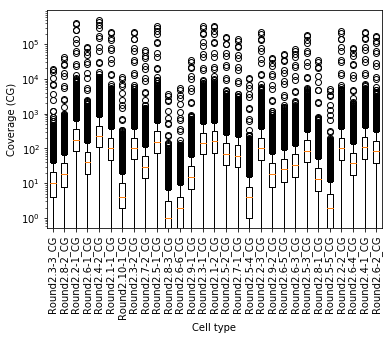

In [42]:
plt.boxplot(cg.iloc[:,:].T, labels=cg.columns);
plt.yscale('log')
plt.ylabel('Coverage (CG)')
plt.xlabel('Cell type')
plt.xticks(rotation=90);

In [43]:
assert( not (mcg.values > cg.values).any())

In [44]:
mlevel = mcg.to_numpy() / cg.to_numpy()
hthresh = 7
mlevel[ cg<hthresh ] = np.nan

df_mlevel = pd.DataFrame(mlevel, columns = mcg.columns, index=df.enh_pos)

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Keeping 24/29 cell types


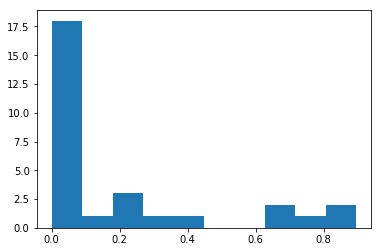

In [45]:
plt.hist((cg<hthresh).mean(axis=0))
good_celltypes = (cg<hthresh).mean(axis=0)<0.5 # Fewer than XX% bad enhancers (low coverage)
# print(np.sum(good_celltypes))
print('Keeping %d/%d cell types' % (np.sum(good_celltypes), len(good_celltypes)))

In [46]:
celltypes = df_mlevel.columns
celltypes = [re.sub("(Round2\.|_mCG)","",c) for c in celltypes]
df_mlevel.columns = celltypes

In [47]:
# Cell type names
df_cellnames = pd.read_csv('/cndd/Public_Datasets/CEMBA/BICCN_minibrain_data/data_freeze/supp_info/clusters_final/cluster_annotation_scf_round2.tsv',
                       sep='\t', index_col='cluster')

# Load ATAC data

In [48]:
atac = pd.read_csv(datadir+'enhancers_reptile_atac_norm.tsv',sep='\t') # Log10(CPM+1)
atac=atac.set_index('enhancer_idx',drop=False)
atac_enh_list = pd.read_csv(datadir+'enhancers_reptile.bed',sep='\t',header=None,names=['chr','start','end'])
atac = atac.join(atac_enh_list)
atac['enh_pos'] = atac['chr'].astype(str)+'_'+atac['start'].astype(str)+'_'+atac['end'].astype(str)
atac = atac.loc[~(atac['chr']=="chrY")]
df_atac = atac.set_index('enh_pos',drop=False)

In [49]:
# Make sure the ATAC and mCG data are both in the same column order
df_atac = df_atac[celltypes]
df_mlevel = df_mlevel[celltypes]

In [50]:
celltypes = df_mlevel.columns
celltypes = [re.sub("(Round2\.|_mCG)","",c) for c in celltypes]

# Kmers

In [53]:
# kdict=np.load(datadir+'kmers_6mers/kmer_dict.npy', allow_pickle=True)

In [54]:
# # Load the kmer data per enhancer
# kmer_counts=np.load(datadir+'kmers_6mers/count.npy')

In [55]:
# kmer_enh = pd.read_csv(datadir+'enhancers_reptile.bed', sep='\t', 
#                        header=None, names=['chr','start','end'])
# kmer_enh['enh_pos'] = ['_'.join([str(i) for i in row]) for ind,row in kmer_enh.iterrows()]

In [56]:
# kmer_enh['enh_num'] = np.arange(kmer_enh.shape[0])

In [57]:
# kmer_enh = kmer_enh.set_index('enh_pos', drop=False)
# kmer_counts.shape

# Prepare the data and save

In [58]:
rna.shape, df_mlevel.shape, df_atac.shape

((9811, 29), (302096, 29), (302094, 29))

In [59]:
# enh_posu
genes2enhu = genes2enh.loc[rna.index]  # Note that this is larger than df_mlevelu
enh_posu = genes2enhu['enh_pos'].unique()
enh_posu = np.intersect1d(df_mlevel.index, enh_posu)
enh_posu = np.intersect1d(df_atac.index, enh_posu)

In [60]:
# Make sure all data frames have the cell types in the same order
genes2enhu = genes2enh.loc[rna.index]  # Note that this is larger than df_mlevelu
df_mlevelu = df_mlevel.loc[enh_posu]
df_atacu = df_atac.loc[enh_posu]
# if (len(kmer_enhu)>0):
#     kmer_enhu = kmer_enh.loc[enh_posu]
# df_mlevelu.shape, df_atacu.shape, kmer_enhu.shape

In [61]:
genes2enhu = genes2enhu.set_index('enh_pos',drop=False)
genes2enhu = genes2enhu.loc[enh_posu]
genes2enhu = genes2enhu.set_index('ensid',drop=False)

In [62]:
ensidu = np.intersect1d(rna.index, genes2enhu.index)
ensidu.shape
rna = rna.loc[ensidu]

In [63]:
# Determine the enhancer number for each gene-enhancer pair
genes2enhu = genes2enhu.loc[rna.index]  # Note that this is larger than df_mlevelu
# genes2enhu['enh_num'] = kmer_enhu.loc[genes2enhu['enh_pos'],'enh_num'].values

In [64]:
# kmer_countsu = kmer_counts[genes2enhu['enh_num'],:]

In [68]:
# Drop the bad cell types
bad_celltypes = mcg.columns[((cg<hthresh).mean(axis=0)>0.5)]
bad_celltypes = [i.replace('Round2.','').replace('_mCG','') for i in bad_celltypes]
rnau = rna.drop(bad_celltypes,axis=1)
df_mlevelu = df_mlevelu.loc[:,rnau.columns]
df_atacu = df_atacu.loc[:,rnau.columns]
assert( (rnau.columns==df_mlevelu.columns).all() )
assert( (rnau.columns==df_atacu.columns).all() )
df_mlevelu.shape, df_atacu.shape, rnau.shape

((242461, 24), (242461, 24), (9811, 24))

In [69]:
# Save the data needed for training
fn_save_prefix = 'RegressData/Regress_data_%dgenes_%dcells_' % (rnau.shape[0], rnau.shape[1])
save_vars = ['genes2enhu', 'rnau', 'df_mlevelu', 'df_atacu','genes']
for var in save_vars:
    fn_save = fn_save_prefix+var+'.pkl'
    eval(var).to_pickle(fn_save)
    print(fn_save)
# np.savez_compressed('RegressData/Regress_Feb16_data_kmer_countsu.npz', kmer_countsu=kmer_countsu)
# print(fn_save_prefix +'kmer_countsu.pkl')

RegressData/Regress_data_9811genes_24cells_genes2enhu.pkl
RegressData/Regress_data_9811genes_24cells_rnau.pkl
RegressData/Regress_data_9811genes_24cells_df_mlevelu.pkl
RegressData/Regress_data_9811genes_24cells_df_atacu.pkl
RegressData/Regress_data_9811genes_24cells_genes.pkl


In [70]:
df_mlevelu

,1-1,1-2,2-1,2-2,2-3,3-1,3-2,3-3,4-1,4-2,...,6-2,6-3,6-4,6-5,7-1,7-2,8-1,8-2,9-1,9-2
enh_pos,,,,,,,,,,,,,,,,,,,,,
chr10_100009732_100010967,0.419738,0.542024,0.637262,0.664619,0.540416,0.676953,0.643587,0.484375,0.556355,0.484056,...,0.141818,0.471429,0.204225,0.495146,0.589633,0.573604,0.570000,0.841727,0.491667,0.606061
chr10_100013831_100014068,0.685185,0.166667,0.437500,0.699115,0.819277,0.370370,0.405063,NaN,0.346535,0.353933,...,0.800000,0.967742,0.880000,1.000000,0.980769,0.958333,0.818182,0.960000,1.000000,0.833333
chr10_100016960_100018009,0.076299,0.156977,0.129489,0.082168,0.426304,0.360158,0.317073,0.114286,0.045677,0.013962,...,0.078571,0.523810,0.162791,0.458333,0.450311,0.465608,0.127273,0.037313,0.306931,0.315068
chr10_100018530_100019593,0.135922,0.038023,0.056159,0.063333,0.134948,0.130901,0.079114,0.035714,0.057143,0.011799,...,0.125490,0.734043,0.109375,0.637168,0.395349,0.354839,0.111111,0.088235,0.017544,0.054545
chr10_100019604_100019864,0.055000,0.053691,0.041575,0.058091,0.099585,0.028871,0.049383,0.058824,0.048780,0.016055,...,0.358974,0.878788,0.446602,0.859649,0.393162,0.493151,0.107143,0.105263,0.000000,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX_99853186_99853303,0.342857,0.350000,0.467742,0.731707,0.640000,0.316667,0.372093,NaN,0.603774,0.504587,...,0.250000,0.125000,0.400000,0.562500,0.545455,0.555556,NaN,0.846154,NaN,NaN
chrX_9997194_9997721,0.821429,0.562500,0.514851,0.784314,0.506494,0.546218,0.400000,0.454545,0.946809,0.959064,...,0.974684,1.000000,0.914894,0.954545,0.962264,1.000000,1.000000,0.933333,NaN,0.346154
chrX_99974800_99975115,0.053333,0.023622,0.000000,0.000000,0.051020,0.006944,0.022727,NaN,0.061728,0.019608,...,0.000000,0.000000,0.000000,0.166667,0.088235,0.230769,0.000000,0.200000,0.000000,0.000000


In [71]:
# Impute the NaN values in mlevel
# df_mlevelu_mean = np.outer(df_mlevelu.median(axis=1).values, df_mlevelu.median(axis=0).values)
df_mlevelu_mean = df_mlevelu.mean(axis=1)
df_mlevelu_mean_mean = df_mlevelu_mean.mean()
df_mlevelu_mean.fillna(df_mlevelu_mean_mean, inplace=True)
# df_mlevelu_mean = pd.DataFrame(df_mlevelu_mean, index=df_mlevelu.index, columns=df_mlevelu.columns)
# df_mlevelu_mean = df_mlevelu_mean.fillna(df_mlevelu.median())
df_mlevelu = df_mlevelu.T.fillna(df_mlevelu_mean, axis=0).T
df_mlevelu.isna().sum()

1-1    0
1-2    0
2-1    0
2-2    0
2-3    0
3-1    0
3-2    0
3-3    0
4-1    0
4-2    0
5-1    0
5-2    0
5-3    0
6-1    0
6-2    0
6-3    0
6-4    0
6-5    0
7-1    0
7-2    0
8-1    0
8-2    0
9-1    0
9-2    0
dtype: int64

In [72]:
assert(not df_mlevelu.isna().any(axis=None))
assert(not df_atacu.isna().any(axis=None))
ensids = rnau.index.values

In [73]:
# Filter out bad enhancers
bad_enh = df_mlevelu.loc[genes2enhu.loc[:,'enh_pos']].isna().any(axis=1)
bad_enh = bad_enh | df_atacu.loc[genes2enhu.loc[:,'enh_pos']].isna().any(axis=1)
good_enh = [not i for i in bad_enh]
genes2enhu = genes2enhu[good_enh]
genes2enhu['enh_num2'] = np.arange(genes2enhu.shape[0])
# kmer_countsu = kmer_countsu[good_enh]
# K = kmer_countsu.shape[1] # Number of K-mers

In [74]:
save_vars = ['df_mlevelu']
for var in save_vars:
    fn_save = fn_save_prefix+var+'.pkl'
    eval(var).to_pickle(fn_save)
    print(fn_save)

RegressData/Regress_data_9811genes_24cells_df_mlevelu.pkl


In [ ]:
# # Gather all the mC and ATAC data into a numpy array for quick indexing
# # %%timeit
# ensids = rnau.index.values
# max_nenh = genes2enhu.loc[:,'gene_chr'].groupby('ensid').count().max()
# Ne = ensids.shape[0]
# Nc = df_mlevelu.shape[1]
# rna_lookup = rnau.loc[ensids].to_numpy()
# ml_lookup = np.zeros((Ne,max_nenh,Nc))
# atac_lookup = np.zeros((Ne,max_nenh,Nc))
# kmeri_lookup = [];
# for i,ens in enumerate(ensids):
#     curr_enh = genes2enhu.loc[ens,['enh_pos','enh_num2']]
#     mlu = df_mlevelu.loc[curr_enh['enh_pos']].to_numpy()
#     atacu = df_atacu.loc[curr_enh['enh_pos']]
#     ml_lookup[i,:mlu.shape[0],:] = mlu
#     atac_lookup[i,:atacu.shape[0],:] = atacu
#     kmeri_lookup.append(curr_enh['enh_num2'])

In [ ]:
# np.savez_compressed(fn_save_prefix+'AllLookups.npz',
#                    ml_lookup=ml_lookup,
#                    atac_lookup=atac_lookup,
#                    rna_lookup=rna_lookup,
#                    kmeri_lookup=kmeri_lookup)